In [201]:
import numpy as np
print("NumPy ", np.__version__)
import tensorflow as tf
print("TensorFlow ", tf.__version__)
tf.compat.v1.disable_eager_execution()
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import matplotlib.pyplot as plt

import os,datetime

from PIL import Image

from vgg import vgg_structure,file_vgg_read
from sklearn.cluster import KMeans

import cv2
from matplotlib.pyplot import imshow

!python -V
import tempfile
import tarfile
import urllib
from io import BytesIO
from matplotlib import gridspec

NumPy  1.22.2
TensorFlow  2.7.0
Python 3.8.8


## Segmentation Masks

In [56]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)


    def run(self, image):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [57]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
          is the color indexed by the corresponding element in the input label
          to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
          map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.imsave('style_seg_mask.jpg', seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
    FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [58]:
def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    try:
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return

    print('running deeplab on image %s...' % url)
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)

In [59]:
MODEL_NAME = 'xception_coco_voctrainaug'
#MODEL_NAME = 'mobilenetv2_coco_voctrainaug'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print("Model will be downloaded to:", download_path)

print(_MODEL_URLS[MODEL_NAME])

print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

Model will be downloaded to: /var/folders/wc/7djdc4j52k739w6gbjnqdsd80000gn/T/tmp0dr7nw0v/deeplab_model.tar.gz
deeplabv3_pascal_train_aug_2018_01_04.tar.gz
downloading model, this might take a while...
download completed! loading DeepLab model...


In [60]:
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


### Content Image Mask

running deeplab on image https://live.staticflickr.com/2838/33968437452_ee0c51fa77_b.jpg...


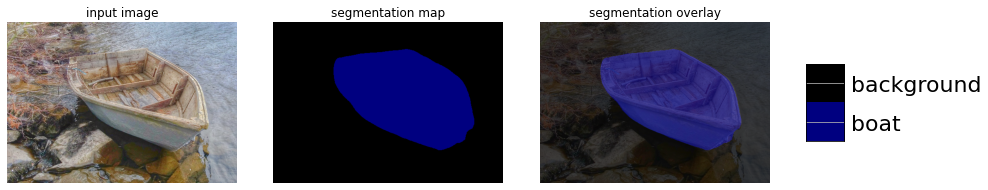

In [240]:
# Perform semantic segmentation on content image
image_url = 'https://live.staticflickr.com/2838/33968437452_ee0c51fa77_b.jpg'
run_visualization(image_url)
os.rename("style_seg_mask.jpg", "content_seg_mask.jpg")

### Style Image Mask

running deeplab on image https://lh3.ggpht.com/uVa5Z0RO5NCbfEac21twB924bP8sgKX7xc_NXhdlxKeLhc5eU9NUFxTYC7Q4=s1200...


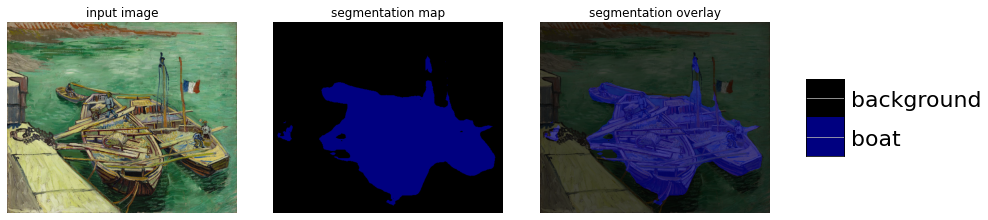

In [241]:
# Perform semantic segmentation on style image
image_url = 'https://lh3.ggpht.com/uVa5Z0RO5NCbfEac21twB924bP8sgKX7xc_NXhdlxKeLhc5eU9NUFxTYC7Q4=s1200'
run_visualization(image_url)

## Image Processing

In [79]:
class Image_Preprocess(object):
    '''Class for pre-processing content & style images and initialize target image.
    
    Attributes:
        content_image : (H,W,C) np.float32 array
        style_image : (H,W,C) np.float32 array
        target_mask_image : (H,W,C) np.float32 array
        style_mask_image : (H,W,C) np.float32 array
        target_masks_origin: (n_masks,H,W) np.float32 array
        style_masks_origin: (n_masks,H,W) np.float32 array
        
    '''
    
    def __init__(self, content_path, style_path, \
                 target_width, target_height, \
                 #Parameters only related to guided style transfer
                 Kmeans_or_NOT = False, \
                 content_mask_path = None, \
                 style_mask_path = None, \
                 mask_n_colors = None, \
                ):
        """
        Args:
            content_path (str) : file path to content image
            style_path (str)   : file path to style image
            target_width (int) : desired width of target image
            target_height (int): desited height of target image

        """
        content_tensor = self.get_image(content_path)
        style_tensor = self.get_image(style_path)
        self.content_image = self.resized_image(content_tensor, target_width, target_height)
        self.style_image = self.resized_image(style_tensor, target_width, target_height)
        # deduct by the color intensity of each pixel by the mean-center given by vgg
        self.content_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        self.style_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        
        if Kmeans_or_NOT:
            # read masks
            content_mask_tensor = self.get_image(content_mask_path)
            style_mask_tensor = self.get_image(style_mask_path)
            content_mask = self.resized_image(content_mask_tensor, \
                                                target_width, target_height)
            style_mask = self.resized_image(style_mask_tensor, \
                                              target_width, target_height)
            # deduct by the color intensity of each pixel by the mean-center given by vgg
            self.target_mask_image = content_mask - np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
            self.style_mask_image =  style_mask -np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
            
            # turn into nparray of shape (H*W,3)
            content_mask_resize = content_mask.reshape(content_mask.shape[0]*content_mask.shape[1], -1)
            style_mask_resize = style_mask.reshape(style_mask.shape[0]*style_mask.shape[1], -1)
            
            # K-means for style image and target image
            kmeans = KMeans(n_clusters=mask_n_colors, random_state=0).fit(style_mask_resize)
            
            target_labels = kmeans.predict(content_mask_resize.astype(np.float32))
            target_labels = target_labels.reshape([content_mask.shape[0], content_mask.shape[1]])
            style_labels = kmeans.predict(style_mask_resize.astype(np.float32))
            style_labels = style_labels.reshape([style_mask.shape[0], style_mask.shape[1]])
            #print(style_labels.shape)
            target_masks = []
            style_masks = []
            
            for i in range(mask_n_colors):
                target_masks.append((target_labels == i).astype(np.float32))
                style_masks.append((style_labels == i).astype(np.float32))
                
            self.target_masks_origin = np.stack(target_masks)
            self.style_masks_origin = np.stack(style_masks)
            
            #print(self.target_masks_origin.shape,self.target_masks_origin.dtype)
            #print(self.style_masks_origin.shape,self.style_masks_origin.dtype)

        
    def get_image(self, image_path):
        '''get image TF tensor.
        
        Returns:
            dtype = (H_origial,W_original,C) tf.float32 tensor
            
        '''
        #image_raw = tf.read_file(image_path)
        image_raw = tf.io.read_file(image_path)
        image_tensor = tf.image.decode_image(image_raw)
        return image_tensor
    
    def resized_image(self, image_tensor, target_width, target_height):
        '''get the resized image nparray.
        
        Returns:
            dtype= (H,W,C) np.float32 array
            
        '''
        with tf.compat.v1.Session() as sess:
            image = sess.run(image_tensor)
            resized_image = sess.run(tf.image.resize(image, (target_width, target_height)))
        return resized_image
    

    def initialize_sythetic_image(self, noise_ratio):
        '''Random uniform initialization mixed with content
        
        Returns:
            dtype= (1,H,W,C) np.float32 array. Note the dimension padding.
            
        '''
        noise_image = np.random.uniform(low=0,high= 256,size= self.content_image.shape).astype(np.float32)
        noise_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        
        return np.expand_dims(noise_image * noise_ratio + self.content_image * (1 - noise_ratio),axis=0)


def save(path, image_unnormalized_nparray):
    '''add back VGG-19 pixel avgs to a processed image represented by a 
    (H,W,C) np.float32 array and save it to path'''
    
    print('adding back pixel averages and saving image to',path)
    image = image_unnormalized_nparray + np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
    print('RGB avg of this image:',np.mean(image,axis=(0,1)))
    #print(image.dtype)
    #avoid overflow of colors, valid range [0,255] inclusive
    image[image>255] = 255
    image[image<0] = 0
    im = Image.fromarray(np.rint(image).astype(np.uint8))
    im.save(path)

def make_dir(path):
    '''create the dir to save data'''
    if os.path.isdir(path):  
        print('dir '+path+' exists, no need to create it.')
        pass
    else:
        print('dir '+path+' did not exist, now created')
        os.mkdir(path)

## Loss Functions, without Kmeans

In [80]:
# Compute the content_loss
def content_loss(content_image_l, process_image_l):
    '''Content loss for one layer
    Args:
        c_tensor: (B,H,W,C) tf.float32 tensor from style image
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, content loss in one layer
    
    '''
    
    diff = content_image_l - process_image_l;
    denominator = tf.cast(tf.size(input=content_image_l), tf.float32)
    
    return tf.nn.l2_loss(diff)/denominator

In [81]:
# Compute the style loss
def style_loss(s_tensor, p_tensor):
    '''Style loss for one layer.
    
    Args:
        s_tensor: (B,H,W,C) tf.float32 tensor from style image
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, style loss in one layer
        
    '''
    
    shape_list = tf.shape(input=s_tensor) #get shape as a list of 4 tf.int32 numbers
    
    M = shape_list[1] * shape_list[2]; N = shape_list[3]
    denominator = tf.cast(2*M*N*N,dtype=tf.float32)
    
    s_tensor_2d = tf.reshape(s_tensor[0], (M, N))
    s_gram = tf.matmul(tf.transpose(a=s_tensor_2d), s_tensor_2d)

    p_tensor_2d = tf.reshape(p_tensor[0], (M, N))
    p_gram = tf.matmul(tf.transpose(a=p_tensor_2d), p_tensor_2d)
    
    diff = (s_gram-p_gram)/denominator
    #denominator = tf.cast(tf.size(content_image_l), tf.float32)

    return tf.nn.l2_loss(diff)

In [82]:
# Compute the variational loss
def variation_loss(p_tensor):
    '''Variational loss for smoothing
    
    Args:
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, variational loss of image tensor
    
    '''
    
    shape_list = tf.shape(input=p_tensor) #get shape as a list of 4 tf.int32 numbers
    
    H = shape_list[1]; W = shape_list[2]; C = shape_list[3]
    #difference between adjacent pixels along height, normalized
    diff1 = (p_tensor[:,1:,:,:] - p_tensor[:,:H-1,:,:])/tf.cast(H*C,tf.float32)
    #difference between adjacent pixels along width, normalized
    diff2 = (p_tensor[:,:,1:,:] - p_tensor[:,:,:W-1,:])/tf.cast(W*C,tf.float32)
    
    #use l2 norm
    return tf.reduce_sum(input_tensor=tf.abs(diff1)) + tf.reduce_sum(input_tensor=tf.abs(diff2))

In [83]:
# Calculate total loss
def sum_loss(content_vgg,style_vgg,
             layer_list_content, layer_list_style, image_group, 
             process_image,w_c,w_s, 
             content_weight, style_weight, variation_weight):
    '''Compute total loss.
    
    Args:
        process_image:  (B,H,W,C) tf.float32 tensor that we want to optimize over
    
    Returns:
        total loss = content_weight*(sum(w_c*content_loss))+style_weight*(sum(w_s*style_loss))
    
    '''
    process_vgg = vgg_structure()
    process_vgg.build(process_image,layers_info)

    # calculating content loss for output of layers in layer_list_content
    contentloss = 0
    i = 0
    for layer_name in layer_list_content:
        output_content = getattr(content_vgg, layer_name) 
        output_process = getattr(process_vgg, layer_name) 
        contentloss += w_c[i] * content_loss(output_content,output_process)
        i += 1
    #contentloss /= float(sum(w_c))
    
    # calculating style loss for output of layers in layer_list_style    
    styleloss = 0
    i = 0
    for layer_name in layer_list_style:
        output_style   = getattr(style_vgg,   layer_name) 
        output_process = getattr(process_vgg, layer_name) 
        styleloss += w_s[i]*style_loss(output_style, output_process)
        i += 1
    #styleloss /= float(sum(w_s))
    
    varloss = variation_loss(process_image)
    
    return content_weight * contentloss + style_weight * styleloss + variation_weight*varloss

## Loss functions, with Kmeans

In [84]:
# Compute the loss based on K-means
# Special cases for with k means
def masked_gram(x, mx, mask_norm, N):
    """
    x = style_features or target_net
    mx = style_masks or target_masks
    mask_norm = mask normalization type
    
    """
    R, a, b = mx.shape # [numberOfMasks, h, w]
    M = a * b

    mx = tf.reshape(mx, [R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(a=x) # N * M
    masked_gram = []
    for i in range(R):
        mask = mx[i]
        #print(mask.shape)
        masked_x = x * mask
        if mask_norm == 'square_sum':
            K = 1. / tf.cast(tf.math.reduce_sum(input_tensor=tf.math.square(mask)), tf.float32)
        elif mask_norm == 'sum':
            K = 1. / tf.cast(tf.math.reduce_sum(input_tensor=mask), tf.float32)
        gram = K * tf.matmul(masked_x, tf.transpose(a=masked_x))
        masked_gram.append(gram)
    return tf.stack(masked_gram)

#if k means
def masked_style_layer_loss(a, ma, x, mx, mask_norm):
    ma = tf.transpose(a=ma[0], perm=[2,0,1]) # [numberOfMasks, h, w]
    mx = tf.transpose(a=mx[0], perm=[2,0,1]) # [numberOfMasks, h, w]
    _, _, _, N = a.get_shape()
    R, _, _ = ma.shape
    #K = 1. / tf.cast(4 * N * N * R, tf.float32)
    A = masked_gram(a, ma, mask_norm, N)
    G = masked_gram(x, mx, mask_norm, N)
    
    denominator = tf.cast(R*N*N,dtype=tf.float32)
    diff = (A-G)/denominator
    
    #loss = K * tf.reduce_sum( tf.pow((G - A), 2) )
    return tf.nn.l2_loss(diff)

In [85]:
# Compute the sum loss for kmeans
def sum_loss_with_mask(content_vgg,style_vgg,style_mask_vgg, target_mask_vgg, mask_norm,
                       layer_list_content, layer_list_style, 
                       image_group, target_image,
                       w_c,w_s,
                       content_weight, style_weight, variation_weight):
    '''Compute total loss when using Kmeans.
    
    Args:
        process_image:  (B,H,W,C) tf.float32 tensor that we want to optimize over
    
    Returns:
        total loss = content_weight*(sum(w_c*content_loss))+style_weight*(sum(w_s*style_loss))
    
    '''
    
    target_vgg = vgg_structure()
    target_vgg.build(target_image,layers_info)

    # calculating content loss for output of layers in layer_list_content
    contentloss = 0
    i = 0
    for layer_name in layer_list_content:
        output_content = getattr(content_vgg, layer_name) 
        output_process = getattr(target_vgg, layer_name) 
        contentloss += w_c[i] * content_loss(output_content,output_process)
        i += 1
    #contentloss /= float(sum(w_c))
    
    # calculating stlye loss for output of layers in layer_list_style    
    styleloss = 0
    i = 0
    for layer_name in layer_list_style:
        output_style   = getattr(style_vgg,   layer_name)
        m_output_style = getattr(style_mask_vgg,   layer_name)
        output_target  = getattr(target_vgg, layer_name) 
        m_output_target = getattr(target_mask_vgg, layer_name) 
        styleloss += w_s[i] * masked_style_layer_loss(output_style, m_output_style ,
                                                      output_target, m_output_target,
                                                      mask_norm)
        i += 1
    #styleloss /= float(sum(w_s))
    
    varloss = variation_loss(target_image)
    
    return content_weight * contentloss + style_weight * styleloss + variation_weight*varloss

## Train

### Adjustable Parameters

In [243]:
'''Image settings.'''
#save to a directory with today's date and run label
output_dir_prefix = datetime.date.today().strftime('%m-%d-%Y') + "_experiment_extensiondemo"

content_path = "content.jpg"
style_path = "style.jpg"
target_width = 400
target_height = 500
layers_info = file_vgg_read("imagenet-vgg-verydeep-19.mat")

# CNN layers info
content_weight = 1e-4 # content weights for total content loss alpha kinda redundant
style_weight = 1 # style weights for total style loss beta 
variation_weight= 1e-5 #variational weight for smoothing
w_c = np.array([1],dtype=np.float32) # content weights for each layer
w_s = np.array([1, 1, 1, 1, 1],dtype=np.float32) # style weights for each layer

layer_list_content = ["conv4_2"]
layer_list_style = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]


'''Optimization settings'''
#How many iters of optimization?
epochs = 101
#Learning rate depends on optimizer choice
lr = 10
noise_ratio = 0.5 # initial noise #MIX content with uniform noise,noise_ratio*noise+(1-noise_ratio) * content

# Record Image every 5 steps in the beginning of training, because it changes faster
# in the initial phase than later.
record_steps_early = 5
record_steps_late = 20

# Hyperparameters tuning
lr_decay_or_NOT = False # True or False (Learning Rate Decay)
optimizer_choice = "adam" #"adam", "gradient_descent", "momentum"

'''Guided Style trasfer settings'''
Kmeans_or_NOT = True
content_mask_path = "content_seg_mask.jpg"
style_mask_path = "style_seg_mask.jpg"
mask_n_colors = 2 # number of clusters for K-means
mask_normalization_type = 'square_sum' #sum or square sum
mask_downsample_type = 'simple' #simple, all, inside, mean

## Variables set up for training

In [244]:
# reset the tensorflow default graph
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()

#global step (current training step, initialized as 0)
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
# global variables: preprocessed image_group
image_group = Image_Preprocess(content_path = content_path, style_path = style_path, \
                               target_width = target_width, target_height = target_height, \
                               #parameters related to Kmeans only
                               Kmeans_or_NOT = Kmeans_or_NOT, \
                               content_mask_path = content_mask_path, \
                               style_mask_path = style_mask_path, \
                               mask_n_colors = mask_n_colors)

# global variable: this is what we want to optimize!
process_image = tf.Variable(image_group.initialize_sythetic_image(noise_ratio), \
                            dtype=tf.float32, trainable = True, name = "process_image")

# save source images before training occurs
make_dir(output_dir_prefix)
save(output_dir_prefix+'/reshaped_content.jpg',image_group.content_image)
save(output_dir_prefix+'/reshaped_style.jpg',image_group.style_image)
if Kmeans_or_NOT:
    save(output_dir_prefix+'/reshaped_content_mask.jpg',image_group.target_mask_image)
    save(output_dir_prefix+'/reshaped_style_mask.jpg',image_group.style_mask_image)
    
# let content and style images go through the vgg net
content_image = np.expand_dims(image_group.content_image.copy(),axis=0)
style_image = np.expand_dims(image_group.style_image.copy(),axis=0)
content_vgg = vgg_structure()
content_vgg.build(content_image,layers_info)
style_vgg = vgg_structure()
style_vgg.build(style_image,layers_info)
# extra stuff if Kmeans is applied
if Kmeans_or_NOT:
    target_masks_origin = image_group.target_masks_origin.copy()
    target_masks_origin = target_masks_origin.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    target_masks_origin = target_masks_origin[np.newaxis, :]
    
    style_masks_origin = image_group.style_masks_origin.copy()
    style_masks_origin = style_masks_origin.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    style_masks_origin = style_masks_origin[np.newaxis, :] 
    
    target_mask_vgg = vgg_structure()
    target_mask_vgg.buildmask(target_masks_origin, mask_downsample_type)

    style_mask_vgg = vgg_structure()
    style_mask_vgg.buildmask(style_masks_origin, mask_downsample_type)

dir 05-24-2022_experiment_extensiondemo did not exist, now created
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/reshaped_content.jpg
RGB avg of this image: [133.04703 126.7055  118.78342]
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/reshaped_style.jpg
RGB avg of this image: [108.01188 128.77467  92.39179]
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/reshaped_content_mask.jpg
RGB avg of this image: [ 0.07211634  0.31661785 33.897026  ]
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/reshaped_style_mask.jpg
RGB avg of this image: [ 0.12307972  0.36176676 35.53549   ]


In [245]:
# parameters to record loss
loss_plot ={}

def train(max_step = epochs, 
          record_steps_early = record_steps_early, 
          record_steps_late = record_steps_late,
          learning_rate = lr, 
          lr_decay_or_NOT = lr_decay_or_NOT,
          #layer_list_content = layer_list_content, 
          #layer_list_style = layer_list_style, 
          #w_c = w_c , w_s = w_s,
          Kmeans_or_NOT = Kmeans_or_NOT,
          optimizer_choice = optimizer_choice
         ):
    '''Minimize total loss function to obtain best syntheized image.
    Args:
        max_steps (int):          number of training epochs/iterations
        record_steps_early(int):  interval for saving image in beginning of optimization
        record_steps_late(int):   interval for saving image in end of optimization
        learning_rate(float):     [initial] learning rate for optimizer
        lr_decay_or_NOT(bool):    whether to use learning rate decay
        Kmeans_or_NOT(bool):      whether to use Guided style transfer
        optimizer_choice(string): 'adam' or 'gradient_descent'
    '''
    
    if Kmeans_or_NOT:
        print("Using masked loss...")
        #loss = sum_loss_with_mask(layer_list_content, layer_list_style,
        #                          image_group, process_image,w_c, w_s,
        #                          mask_normalization_type,content_weight,style_weight)
        loss = sum_loss_with_mask(content_vgg,style_vgg,
                                  style_mask_vgg, target_mask_vgg, mask_normalization_type,
                                  layer_list_content, layer_list_style,
                                  image_group, process_image,
                                  w_c,w_s,
                                  content_weight, style_weight, variation_weight)
    else:
        print("Using original loss...")    
        loss = sum_loss(content_vgg,style_vgg,
                        layer_list_content, layer_list_style, \
                        image_group, process_image, 
                        w_c, w_s,content_weight,style_weight,variation_weight)
        
    if lr_decay_or_NOT:
        print("Using learning rate decay...")
        starter_learning_rate = learning_rate
        end_learning_rate = learning_rate/10
        decay_steps = 500
        learning_rate = tf.compat.v1.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=1)
        
    # Optimizer
    if optimizer_choice == "gradient_descent":
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
        print("Using GradientDescentOptimizer...")
    elif optimizer_choice == "adam":
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
        print("Using AdamOptimizer...")
    elif optimizer_choice == "momentum":
        optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate)
        print("Using MomentumOptimizer...")
    else:
        raise ValueError("Invalid optimizer.")
    
    train_step = optimizer.minimize(loss)
    
    import time
    start = time.time()
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        
        initial_step = global_step.eval()
        print("training begin!")
        
        for step in np.arange(initial_step, max_step):
            #print('step',step)
            
            sess.run(train_step)
            
            if (step <= max_step//4 and step % record_steps_early == 0) or \
               (step > max_step//4 and step % record_steps_late == 0):
                
                if Kmeans_or_NOT:
                    loss_val = sess.run(loss)
                else:
                    loss_val = sess.run(loss)
                
                loss_plot[step+1] = loss_val
                print(" \n Step {}  Total loss: {:5.1f}".format(step + 1, loss_val))
                
                result_image = sess.run(process_image)[0]
                print("\n Step {}   Sum of all pixels: {:5.1f}".format(step + 1, np.sum(result_image)))
                
                # save the image during the training process
                filename = output_dir_prefix+"/step_%d.png" % step
                save(filename, result_image)
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    with open(output_dir_prefix+"/time.txt", "a") as ioufile:
            ioufile.write(str(end-start))

## Go

In [246]:
train()

Using masked loss...
Using AdamOptimizer...
training begin!
 
 Step 1  Total loss: 2528.2

 Step 1   Sum of all pixels: 7326361.5
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/step_0.png
RGB avg of this image: [130.01823 128.41566 122.59387]
 
 Step 6  Total loss: 646.4

 Step 6   Sum of all pixels: 6720156.5
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/step_5.png
RGB avg of this image: [125.76878 135.7197  116.50954]
 
 Step 11  Total loss: 293.8

 Step 11   Sum of all pixels: 5580649.0
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/step_10.png
RGB avg of this image: [122.6972  140.43982 109.16346]
 
 Step 16  Total loss: 160.9

 Step 16   Sum of all pixels: 4595385.0
adding back pixel averages and saving image to 05-24-2022_experiment_extensiondemo/step_15.png
RGB avg of this image: [121.02533 141.97224 104.37665]
 
 Step 21  Total loss: 108.9

 Step 21   Sum of all pixels: 

### Plot total loss vs. iterations

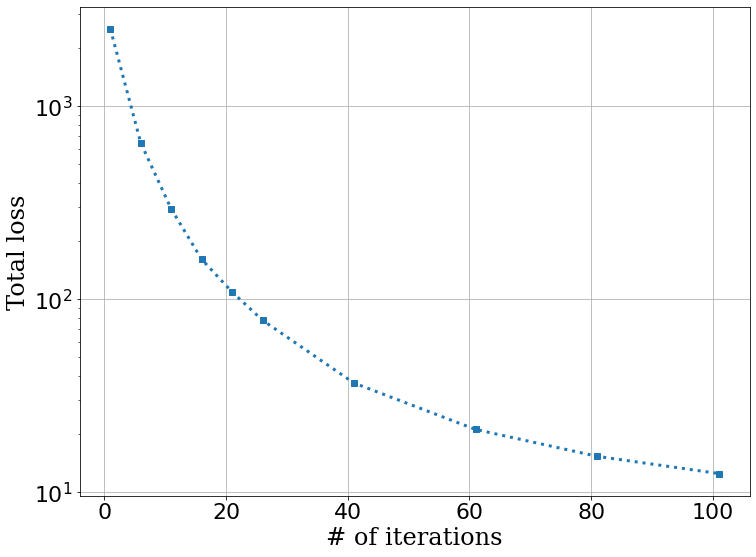

In [247]:
# save total loss
np.savetxt(output_dir_prefix+"/total_loss.txt", [list(loss_plot.keys()), list(loss_plot.values())], delimiter=',')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,}

plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.rcParams["figure.figsize"] = (12,9)
plt.xlabel("# of iterations",fontdict=font)
plt.ylabel("Total loss",fontdict=font)
plt.plot(list(loss_plot.keys()), list(loss_plot.values()),'s:',linewidth =3)
plt.yscale('log')

plt.grid()
plt.savefig(output_dir_prefix+'/loss_vs_iter.png',dpi=300)

## Canny Edge Detector

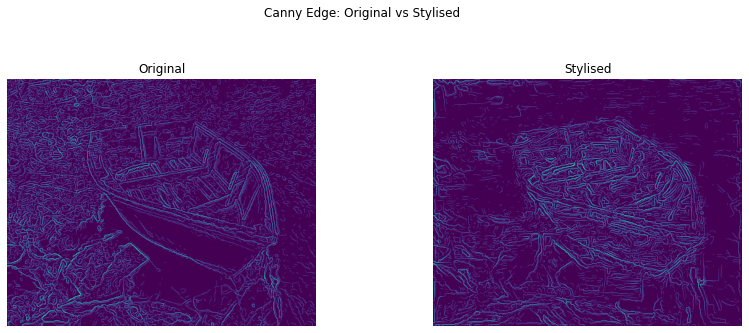

In [249]:
# defining the canny detector function

# here weak_th and strong_th are thresholds for
# double thresholding step
def Canny_detector(img, weak_th = None, strong_th = None):

    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
    # Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)

    # setting the minimum and maximum thresholds
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5

    # getting the dimensions of the input image
    height, width = img.shape

    # Looping through every pixel of the grayscale
    # image
    for i_x in range(width):
        for i_y in range(height):

                grad_ang = ang[i_y, i_x]
                grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)

                # selecting the neighbours of the target pixel
                # according to the gradient direction
                # In the x axis direction
                if grad_ang<= 22.5:
                    neighb_1_x, neighb_1_y = i_x-1, i_y
                    neighb_2_x, neighb_2_y = i_x + 1, i_y

                # top right (diagonal-1) direction
                elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                    neighb_1_x, neighb_1_y = i_x-1, i_y-1
                    neighb_2_x, neighb_2_y = i_x + 1, i_y + 1

                # In y-axis direction
                elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                    neighb_1_x, neighb_1_y = i_x, i_y-1
                    neighb_2_x, neighb_2_y = i_x, i_y + 1
            
                # top left (diagonal-2) direction
                elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                    neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                    neighb_2_x, neighb_2_y = i_x + 1, i_y-1
            
                # Now it restarts the cycle
                elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                    neighb_1_x, neighb_1_y = i_x-1, i_y
                    neighb_2_x, neighb_2_y = i_x + 1, i_y
            
                # Non-maximum suppression step
                if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                    if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                        mag[i_y, i_x]= 0
                        continue

                if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                    if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                        mag[i_y, i_x]= 0

    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)
    ids = np.zeros_like(img)
    
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
            
            grad_mag = mag[i_y, i_x]
            
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2

    # finally returning the magnitude of
    # gradients of edges
    return mag


org = cv2.imread(output_dir_prefix+"/reshaped_content.jpg")

frame = cv2.imread(output_dir_prefix+"/step_100.png")

# calling the designed function for
# finding edges
canny_org = Canny_detector(org)
canny_img = Canny_detector(frame)


#Displaying the input and output image

plt.figure(figsize=(14, 10))
plt.suptitle("Canny Edge: Original vs Stylised")
plt.subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
imshow(canny_org);
plt.imsave(output_dir_prefix+'/original_canny.jpg',canny_org)

plt.subplot(2, 2, 2)
plt.title("Stylised")
plt.axis('off')
imshow(canny_img);
plt.imsave(output_dir_prefix+'/stylised_canny.jpg',canny_img)

References:
1. https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb
2. https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/pascal.md
3. https://github.com/NELSONZHAO/zhihu/tree/master/image_style_transfer?1529570173001&fbclid=IwAR3mjQzn6yGLKmdJ5aU8h0L4SqtQuP12YIAExTnlIfHsj9PGuU-ssYPhcvs
4. https://github.com/wzirui/guided-neural-style
5. https://www.geeksforgeeks.org/implement-canny-edge-detector-in-python-using-opencv/